In [2]:
import ijson
import numpy as np
import json
from decimal import Decimal
import json
import time
import torch
import warnings
import pennylane as qml
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import clear_output

In [5]:
datos = []
def cargar_datos_json(json_path, num_jets=10000, num_constituents=10):
    with open(json_path, 'r') as f:
        data = json.load(f)

    eventos = []
    for i, evento in enumerate(data[:num_jets]):
        jet_pt, jet_eta, jet_phi, _ = evento['jet_kinematics']
        constituents = evento['PFCands']

        # Calcular pT para cada constituyente
        constituents = np.array(constituents)
        px = constituents[:, 0]
        py = constituents[:, 1]
        pt = np.sqrt(px**2 + py**2)

        # Índices de los 10 con mayor pT
        indices_ordenados = np.argsort(pt)[::-1][:num_constituents]
        top_cands = constituents[indices_ordenados]

        # Convertir cada uno a formato usado en el circuito
        top_constituents = []
        for cand in top_cands:
            px, py, pz, E = cand[0:4]
            pt = np.sqrt(px**2 + py**2)
            eta = 0.5 * np.log((E + pz) / (E - pz + 1e-8))  # evitar división por 0
            phi = np.arctan2(py, px)
            top_constituents.append({
                'pt': pt,
                'eta': eta,
                'phi': phi
            })

        eventos.append({
            'pt_jet': jet_pt,
            'eta_jet': jet_eta,
            'phi_jet': jet_phi,
            'constituents': top_constituents
        })

    return eventos

datos = cargar_datos_json('runG_batch0_reducido.json')

In [3]:
import json
import numpy as np

def cargar_datos_json(json_path, num_jets=2000, num_constituents=10):
    with open(json_path, 'r') as f:
        data = json.load(f)

    eventos = []
    for i, evento in enumerate(data[:num_jets]):
        # Extraer información del jet
        jet_pt = evento.get('jet_pt', i)
        jet_eta = evento.get('jet_eta', i)
        jet_phi = evento.get('jet_phi', i)
        
        # Extraer constituyentes (partículas)
        part_px = np.array(evento.get('part_px', []))
        part_py = np.array(evento.get('part_py', []))
        part_pz = np.array(evento.get('part_pz', []))
        part_energy = np.array(evento.get('part_energy', []))
        
        # Calcular pt, eta, phi para cada constituyente
        pt = np.sqrt(part_px**2 + part_py**2)
        p_total = np.sqrt(part_px**2 + part_py**2 + part_pz**2)
        theta = np.arccos(part_pz / (p_total + 1e-8))  # Evitar división por cero
        eta = -np.log(np.tan(theta / 2 + 1e-8))
        phi = np.arctan2(part_py, part_px)
        
        # Seleccionar los num_constituents con mayor pt
        indices_ordenados = np.argsort(pt)[::-1][:num_constituents]
        
        top_constituents = []
        for idx in indices_ordenados:
            top_constituents.append({
                'pt': pt[idx],
                'eta': eta[idx],
                'phi': phi[idx],
                'px': part_px[idx],
                'py': part_py[idx],
                'pz': part_pz[idx],
                'energy': part_energy[idx],
                'charge': evento['part_charge'][idx] if 'part_charge' in evento else 0
            })
            
        eventos.append({
            'pt_jet': jet_pt,
            'eta_jet': jet_eta,
            'phi_jet': jet_phi,
            'constituents': top_constituents
        })

    return eventos

# Ejemplo de uso
datos_HToBB = cargar_datos_json('HToBB_120.json', num_jets=2000, num_constituents=10)
datos_ZToQQ = cargar_datos_json('ZToQQ_120.json', num_jets=2000, num_constituents=10)

In [6]:
from sklearn.model_selection import train_test_split

datos = np.array(datos)

# Dividir en train y test (80% - 20%)
X_train, X_test = train_test_split(
    datos, 
    test_size=0.2,      # 20% para test
    random_state=42,    # Semilla para reproducibilidad
    shuffle=True        # Mezclar datos antes de dividir
)

> ***“Each event is represented by a set of reconstructed jets ordered by decreasing transverse momentum (pT)…"***

Siguiendo con lo especificado en el paper....

\begin{align}
f \cdot \frac{p_T}{p_{T,\text{jet}}} \cdot (\eta - \eta_{\text{jet}}) \rightarrow \theta \tag{1} \\
f \cdot \frac{p_T}{p_{T,\text{jet}}} \cdot (\phi - \phi_{\text{jet}}) \rightarrow \varphi \tag{2} \\
(p_T, \eta, \phi) \rightarrow |\psi\rangle = R_X(\varphi)R_Y(\theta) |0\rangle \notag \\
= \alpha(\theta, \varphi) |0\rangle + \beta(\theta, \varphi) |0\rangle \tag{3} \\
f \rightarrow 1 + \frac{2\pi}{1+e^{-w}} \tag{4}
\end{align}


In [151]:
#Declaro la funcion 'f = f(w)' que tiene pinta que va a ser ese hiperparámtro que vamos a tener que ir mejorando
def f(w):
  return 1 + (2* np.pi / (1 + np.exp(-w)))

def phi_circuit(w, Phi, Phi_jet, Pt, Pt_jet):
  return f(w) * Pt / Pt_jet * (Phi - Phi_jet)

def theta_circuit(w, Theta, Theta_jet, Pt, Pt_jet):
  return f(w) * Pt / Pt_jet * (Theta - Theta_jet)


In [152]:
num_jets_train = len(filtered_data_float_train)
num_jets_test = len(filtered_data_float_test)
print("Numbero de evetos de entrenamiento: ", num_jets_train)
print("Numbero de evetos de test: ", num_jets_test)

Numbero de evetos de entrenamiento:  9985
Numbero de evetos de test:  2494


### ⚠️⚠️ **Funciones que cree SOLO para mostrar como se visualizarian los jets en la esfera de bloch** (para un ejemplo pasado de 10 eventos solo )
Puede ser útil para visualizar cosas y orientarnos un poco. Si ves nombres de variables que no coinciden es qprque fuí evolucionando el resto del código y esto quedó ahí estancado, para no perder las imágenes.

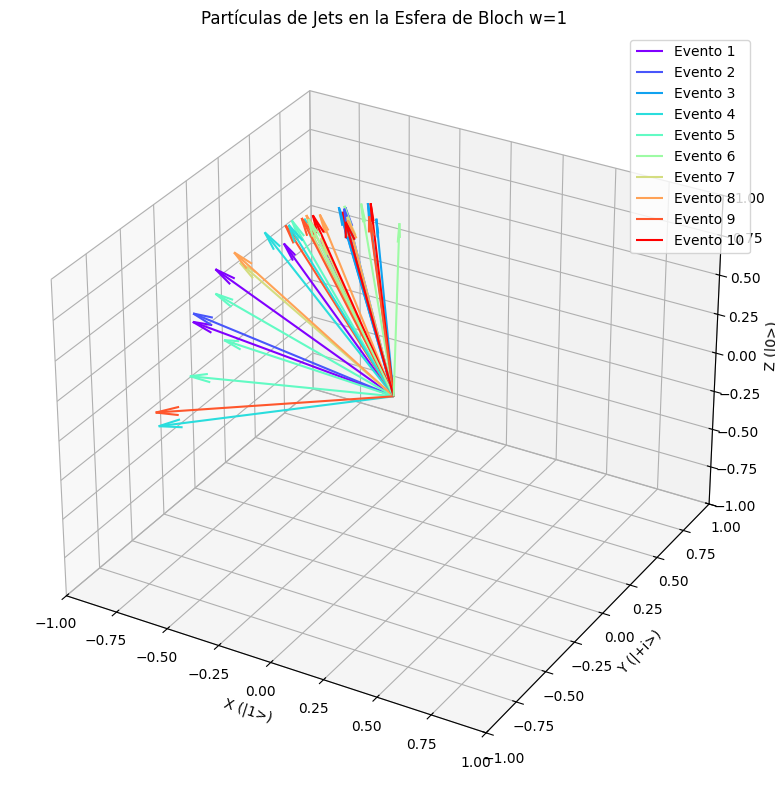

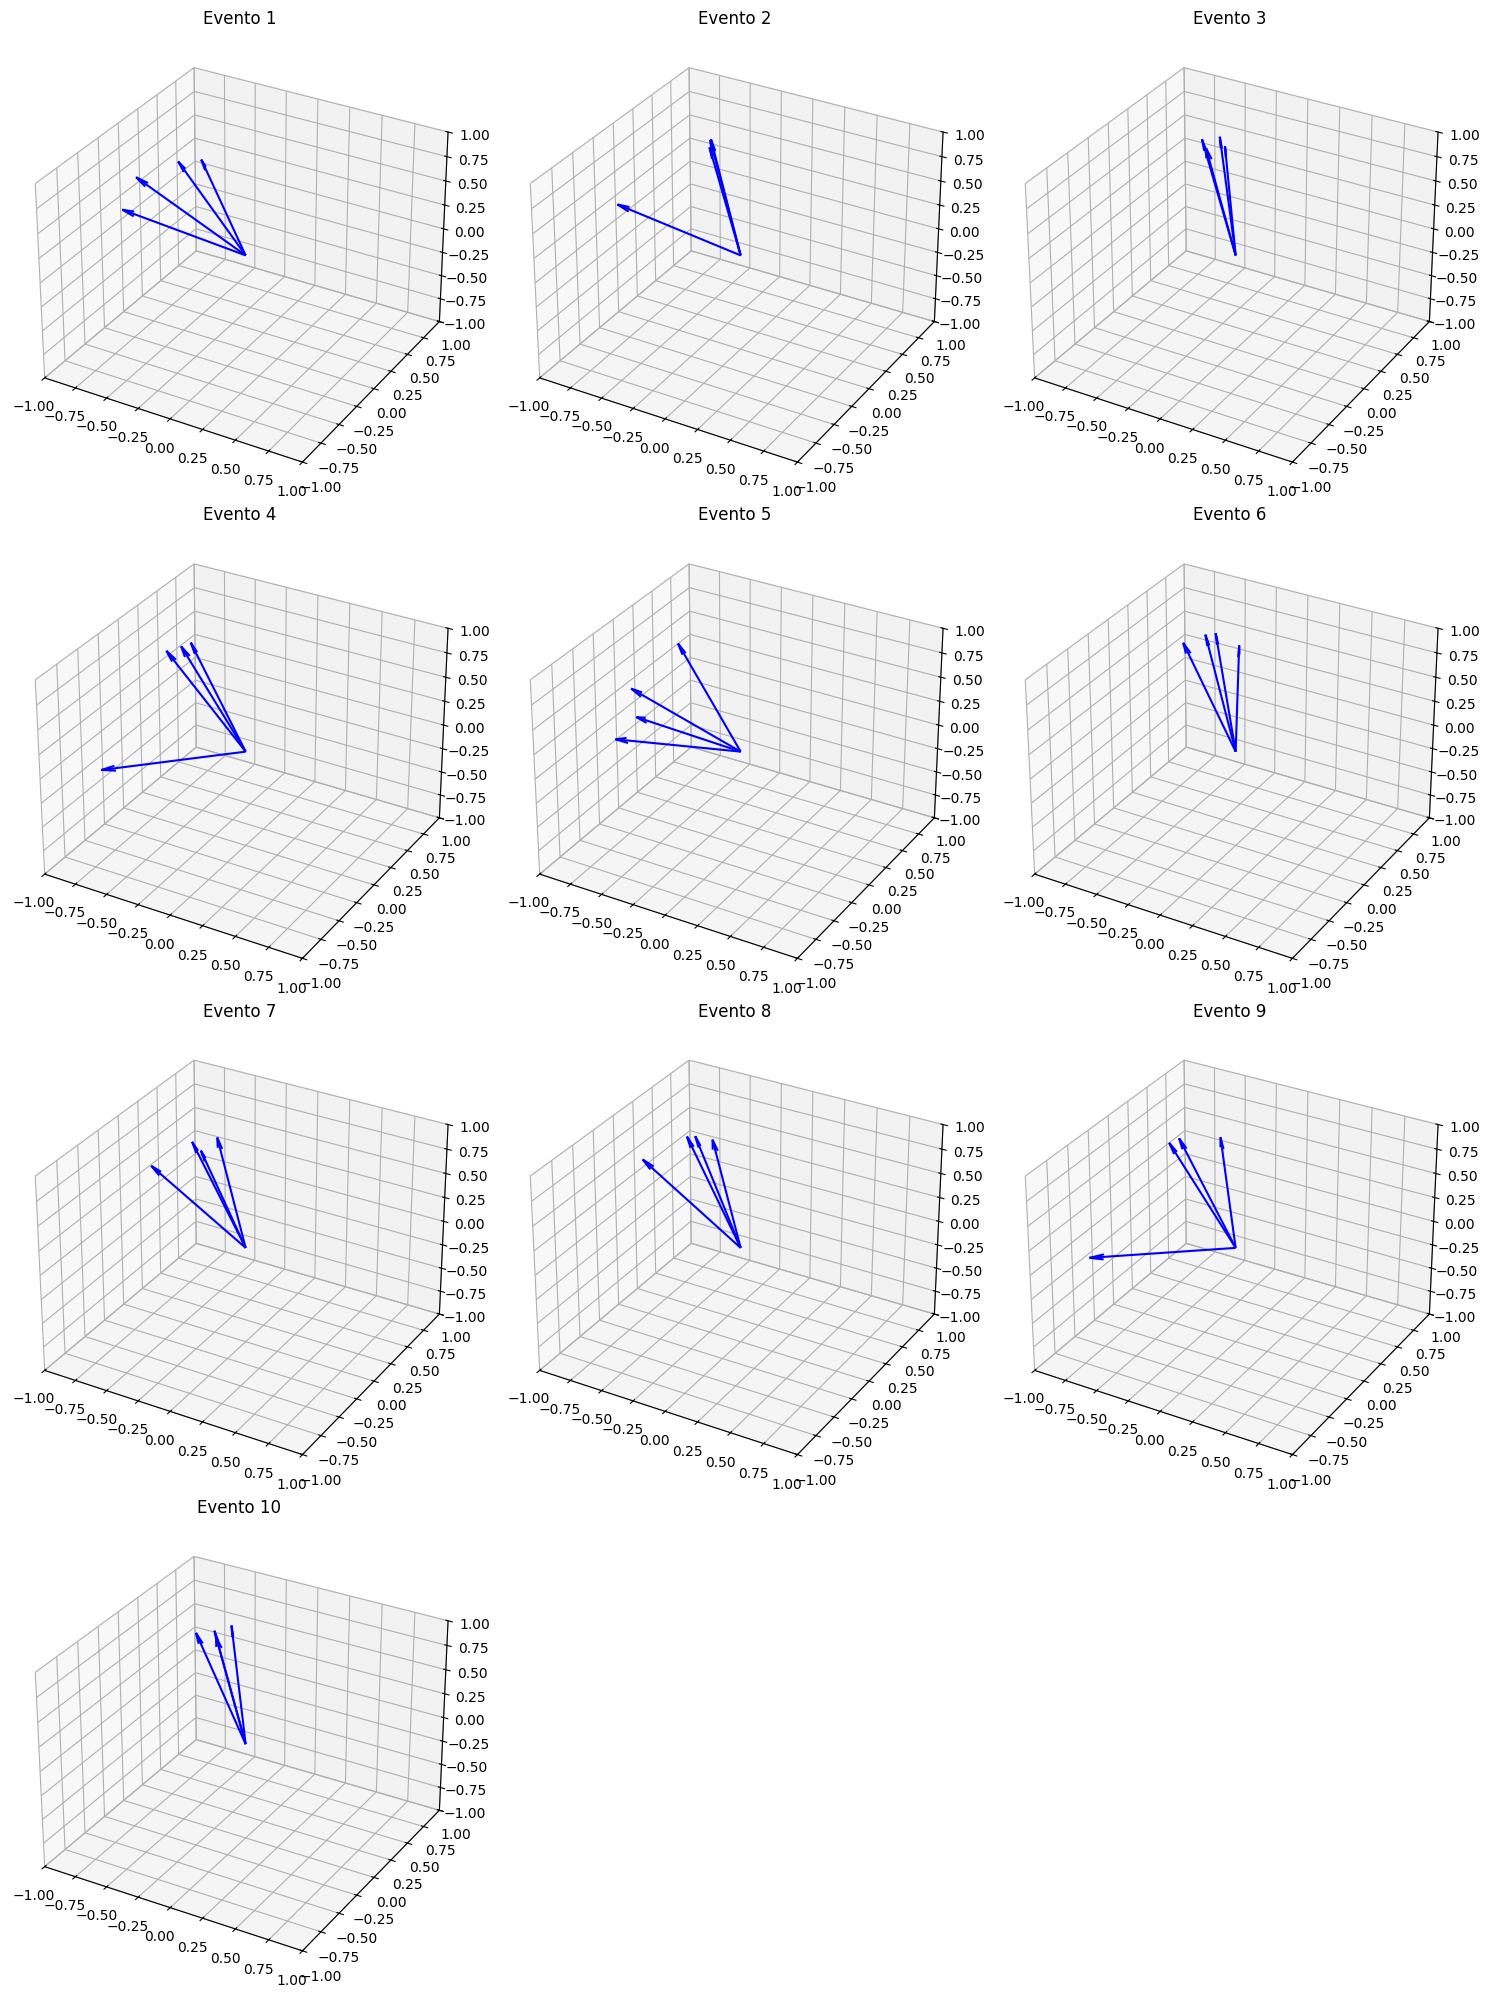

In [158]:
from qiskit import QuantumCircuit
from qiskit.quantum_info import Statevector
from qiskit.visualization import plot_bloch_multivector
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import matplotlib.cm as cm

def plot_jets_on_bloch(jets_data, num_particles=10):
    # Configurar colores distintos para cada jet
    colors = cm.rainbow(np.linspace(0, 1, len(jets_data)))

    # Crear figura 3D para la esfera de Bloch
    fig = plt.figure(figsize=(12, 8))
    ax = fig.add_subplot(111, projection='3d')

    for jet_idx, jet in enumerate(jets_data):
        if 'Jets' not in jet:
            continue

        # Tomar las primeras 'num_particles' partículas del jet
        particles = jet['Jets'][:num_particles]

        for part_idx, particle in enumerate(particles):
            # Calcular theta y phi según el esquema 1P1Q
            phi = phi_circuit(1, particle['phi'], phi_jet, particle['pt'], pt_jet)
            theta = theta_circuit(1, particle['eta'], eta_jet, particle['pt'], pt_jet)

            # Crear circuito cuántico para esta partícula
            qc = QuantumCircuit(1)
            qc.ry(theta, 0)
            qc.rx(phi, 0)

            # Obtener el estado cuántico
            state = Statevector.from_instruction(qc)
            bloch = state.data

            # Convertir a coordenadas cartesianas
            x = 2 * np.real(np.conj(bloch[0]) * bloch[1])
            y = 2 * np.imag(np.conj(bloch[0]) * bloch[1])
            z = abs(bloch[0])**2 - abs(bloch[1])**2

            # Graficar el vector con color específico para este jet
            ax.quiver(0, 0, 0, x, y, z,
                      color=colors[jet_idx],
                      arrow_length_ratio=0.1,
                      label=f'Evento {jet_idx+1}' if part_idx == 0 else "")

    # Configuración del gráfico
    ax.set_xlim([-1, 1])
    ax.set_ylim([-1, 1])
    ax.set_zlim([-1, 1])
    ax.set_xlabel('X (|1>)')
    ax.set_ylabel('Y (|+i>)')
    ax.set_zlabel('Z (|0>)')
    ax.set_title('Partículas de Jets en la Esfera de Bloch w=1')

    # Mostrar leyenda
    ax.legend()
    plt.tight_layout()
    plt.show()

# Función alternativa para mostrar cada jet en una esfera separada
def plot_jets_separate_bloch(jets_data, num_particles=10):
    num_jets = len(jets_data)
    cols = 3  # Número de columnas en el grid
    rows = (num_jets + cols - 1) // cols

    fig = plt.figure(figsize=(cols*5, rows*5))

    for jet_idx, jet in enumerate(jets_data):
        if 'Jets' not in jet:
            continue

        ax = fig.add_subplot(rows, cols, jet_idx+1, projection='3d')
        particles = jet['Jets'][:num_particles]

        for particle in particles:
            phi = phi_circuit(1, particle['phi'], phi_jet, particle['pt'], pt_jet)
            theta = theta_circuit(1, particle['eta'], eta_jet, particle['pt'], pt_jet)

            qc = QuantumCircuit(1)
            qc.ry(theta, 0)
            qc.rx(phi, 0)

            state = Statevector.from_instruction(qc)
            bloch = state.data

            x = 2 * np.real(np.conj(bloch[0]) * bloch[1])
            y = 2 * np.imag(np.conj(bloch[0]) * bloch[1])
            z = abs(bloch[0])**2 - abs(bloch[1])**2

            ax.quiver(0, 0, 0, x, y, z,
                      color='blue',
                      arrow_length_ratio=0.1)

        ax.set_xlim([-1, 1])
        ax.set_ylim([-1, 1])
        ax.set_zlim([-1, 1])
        ax.set_title(f'Evento {jet_idx+1}')

    plt.tight_layout()
    plt.show()

# Ejemplo de uso:
plot_jets_on_bloch(filtered_data_float_train[:10])  # Todos los jets en una esfera
plot_jets_separate_bloch(filtered_data_float_train[:10])  # Jets en esferas separadas

---
---
---
---

# **Código del paper**

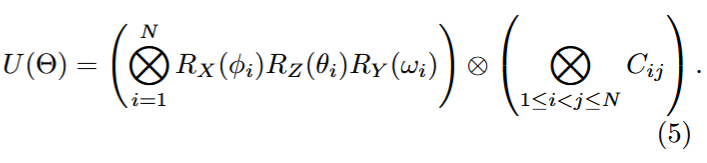

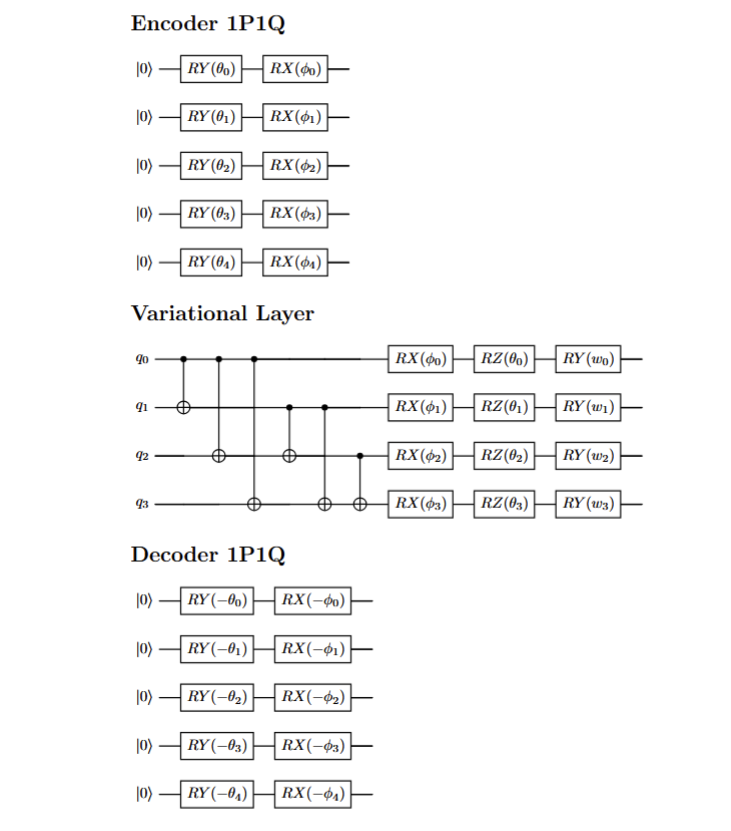

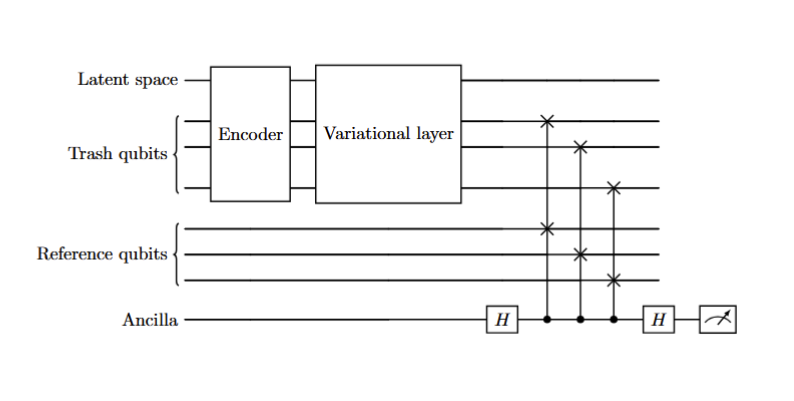

In [9]:
import pennylane as qml
import torch

# --- Parámetros del circuito ---
num_particles = 10
num_latent = 2
num_ref = num_particles - num_latent
num_trash = num_ref
wires = list(range(num_particles + num_ref + 1))  # +1 ancilla
ancilla = wires[-1]
dev = qml.device("default.qubit", wires=wires)

latent_wire = 0
trash_wires = wires[1:num_particles]
ref_wires = wires[num_particles:-1]


# --- Codificación 1P1Q (misma que en el paper) ---
def f(w):
    return 1 + (2 * np.pi / (1 + torch.exp(-w)))

def phi_circuit(w, phi, phi_jet, pt, pt_jet):
    return f(w) * pt / pt_jet * (phi - phi_jet)

def theta_circuit(w, eta, eta_jet, pt, pt_jet):
    return f(w) * pt / pt_jet * (eta - eta_jet)


# --- Encoder 1P1Q adaptado al nuevo formato de jet ---
def encode_1p1q(jet, w):
    pt_jet = jet['pt_jet']
    eta_jet = jet['eta_jet']
    phi_jet = jet['phi_jet']
    constituents = jet['constituents']

    for i in range(num_particles):
        c = constituents[i]
        theta = theta_circuit(w, c['eta'], eta_jet, c['pt'], pt_jet)
        phi = phi_circuit(w, c['phi'], phi_jet, c['pt'], pt_jet)
        qml.RY(theta, wires=i)
        qml.RX(phi, wires=i)


# --- Capa variacional ---
def variational_layer(theta_i, phi_i, w_i, num_layers):
    for layer in range(num_layers):
        for i in range(num_particles):
            for j in range(i + 1, num_particles):
                qml.CNOT(wires=[i, j])

        for i in range(num_particles):
            qml.RX(phi_i[layer, i], wires=i)
            qml.RZ(theta_i[layer, i], wires=i)
            qml.RY(w_i[layer, i], wires=i)


# --- QAE Circuit ---
@qml.qnode(dev, interface="torch", diff_method="backprop")
def qae_circuit(jet, w, theta_i, phi_i, w_i, num_layers):
    encode_1p1q(jet, w)
    variational_layer(theta_i, phi_i, w_i, num_layers)

    for trash_wire, ref_wire in zip(trash_wires, ref_wires):
        qml.Hadamard(wires=ancilla)
        qml.CSWAP(wires=[ancilla, trash_wire, ref_wire])
        qml.Hadamard(wires=ancilla)

    return qml.probs(wires=ancilla)


# --- Cost function para entrenamiento ---
def cost_function_with_fidelity(jet, w, theta_i, phi_i, w_i, num_layers):
    prob_0 = qae_circuit(jet, w, theta_i, phi_i, w_i, num_layers)[0]
    fidelity = prob_0
    return -fidelity, fidelity.item()


# --- Utilidad (no necesaria si ya tienes los jets procesados) ---
def encontrar_maximos_per_jet(jet):
    max_pt = jet['pt_jet']
    max_eta = jet['eta_jet']
    max_phi = jet['phi_jet']
    return max_pt, max_eta, max_phi


In [12]:
import torch
import numpy as np

# --- Inicialización de parámetros ---
w = torch.tensor(1.0, requires_grad=True)
num_layers = 1
theta_i = (torch.rand(num_layers, num_particles) * 2 * torch.pi).requires_grad_(True)
phi_i   = (torch.rand(num_layers, num_particles) * 2 * torch.pi).requires_grad_(True)
w_i     = (torch.rand(num_layers, num_particles) * 2 * torch.pi).requires_grad_(True)

optimizer = torch.optim.Adam(
    [w, theta_i, phi_i, w_i],
    lr=0.01,
    betas=(0.9, 0.999),
    eps=1e-08,
    weight_decay=0.01,
    amsgrad=True
)

num_epochs = 1
all_fidelities = []
event_fidelities = []

# Asegúrate de tener tus datos cargados como:
# X_train = cargar_datos_json("runG_batch0_reducido.json")

# --- Entrenamiento ---
for epoch in range(num_epochs):
    total_loss = 0.0
    epoch_fidelities = []

    for jet in X_train:
        # Verificar que haya suficientes constituyentes
        if len(jet['constituents']) < num_particles:
            continue

        loss, fidelity = cost_function_with_fidelity(jet, w, theta_i, phi_i, w_i, num_layers)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        epoch_fidelities.append(fidelity)
        event_fidelities.append(fidelity * 100)  # en %

    avg_loss = total_loss / len(epoch_fidelities)
    avg_fidelity = np.mean(epoch_fidelities) * 100
    all_fidelities.append(avg_fidelity)

    print(f"Epoch {epoch+1}, Loss: {avg_loss:.4f}, Avg Fidelity: {avg_fidelity:.2f}%")


Epoch 1, Loss: -0.9704, Avg Fidelity: 97.04%


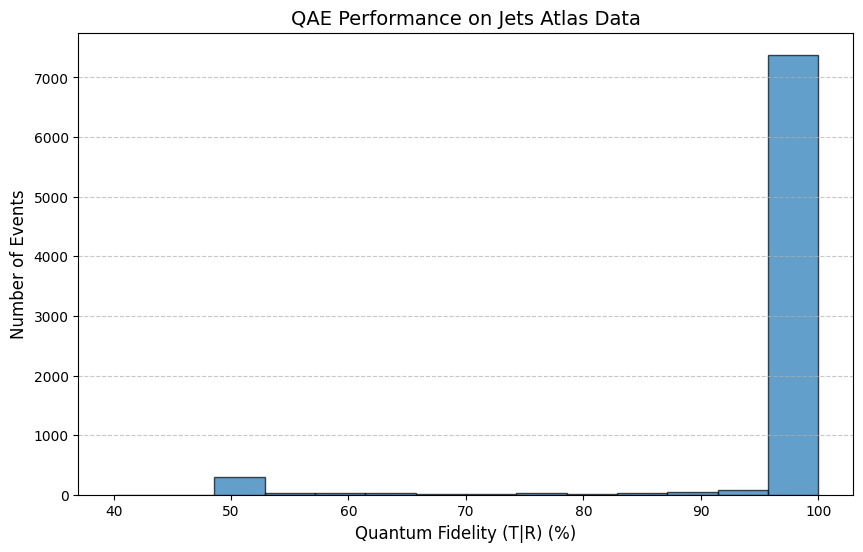

In [13]:
# --- Generación del Diagrama ---
plt.figure(figsize=(10, 6))
plt.hist(event_fidelities, bins=np.linspace(40, 100, 15), edgecolor='black', alpha=0.7)
plt.xlabel("Quantum Fidelity (T|R) (%)", fontsize=12)
plt.ylabel("Number of Events", fontsize=12)
plt.title("QAE Performance on Jets Atlas Data", fontsize=14)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.savefig("qae_fidelity_distribution.png", dpi=300, bbox_inches='tight')
plt.show()

# Hora de la validación

In [40]:
from sklearn.metrics import roc_auc_score

event_fidelities_back = []
event_fidelities_HToBB = []
event_fidelities_ZToQQ = []
fidelidades = []
etiquetas = []

X_test_2 = X_test
for jet in X_test_2:
    # Verificar que haya suficientes constituyentes
    if len(jet['constituents']) < num_particles:
        continue
    _, fidelity = cost_function_with_fidelity(jet, w, theta_i, phi_i, w_i, num_layers)
    event_fidelities_back.append(fidelity * 100) 
    fidelidades.append(fidelity)
    etiquetas.append(0)

print("Terminada prueba de validación")

for jet in datos_HToBB:
    # Verificar que haya suficientes constituyentes
    if len(jet['constituents']) < num_particles:
        continue
    _, fidelity = cost_function_with_fidelity(jet, w, theta_i, phi_i, w_i, num_layers)
    event_fidelities_HToBB.append(fidelity * 100) 
    fidelidades.append(fidelity)
    etiquetas.append(1)

print("Terminada prueba con HToBB")

for jet in datos_ZToQQ:
    # Verificar que haya suficientes constituyentes
    if len(jet['constituents']) < num_particles:
        continue
    _, fidelity = cost_function_with_fidelity(jet, w, theta_i, phi_i, w_i, num_layers)
    event_fidelities_ZToQQ.append(fidelity * 100) 
    fidelidades.append(fidelity)
    etiquetas.append(1)

print("Terminada prueba con ZToQQ")

Terminada prueba de validación
Terminada prueba con HToBB
Terminada prueba con ZToQQ


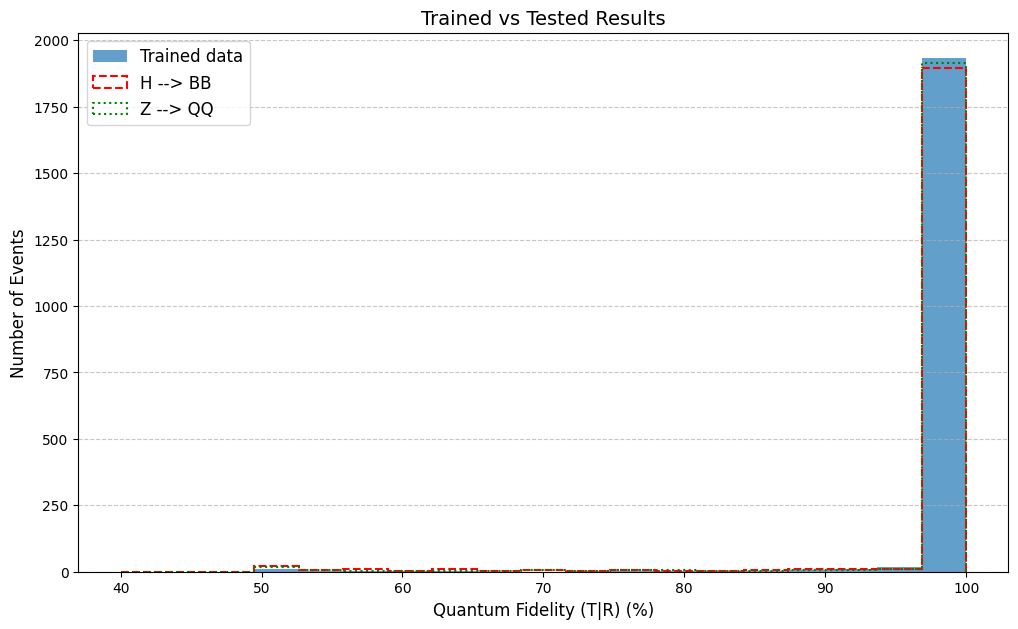

In [50]:
plt.figure(figsize=(12, 7))

# Definir bins
bins = np.linspace(40, 100, 20)

plt.hist(event_fidelities_back, bins=np.linspace(40, 100, 20), alpha=0.7, label='Trained data',)

# 2. Exotic (solo bordes, sin relleno)
plt.hist(event_fidelities_HToBB, 
         bins=bins, 
         edgecolor='red', 
         facecolor='none',  # Relleno transparente
         linewidth=1.5,     # Grosor del borde
         linestyle='--',    # Estilo de línea (opcional)
         label='H --> BB',
         histtype='step',  # Solo bordes
         stacked=True)

plt.hist(event_fidelities_ZToQQ, 
         bins=bins, 
         edgecolor='green', 
         facecolor='none',  # Relleno transparente
         linewidth=1.5,     # Grosor del borde
         linestyle=':',    # Estilo de línea (opcional)
         label='Z --> QQ',
         histtype='step',  # Solo bordes
         stacked=True)

# Personalización
plt.xlabel("Quantum Fidelity (T|R) (%)", fontsize=12)
plt.ylabel("Number of Events", fontsize=12)
plt.title("Trained vs Tested Results", fontsize=14)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.legend(fontsize=12)
plt.show() 

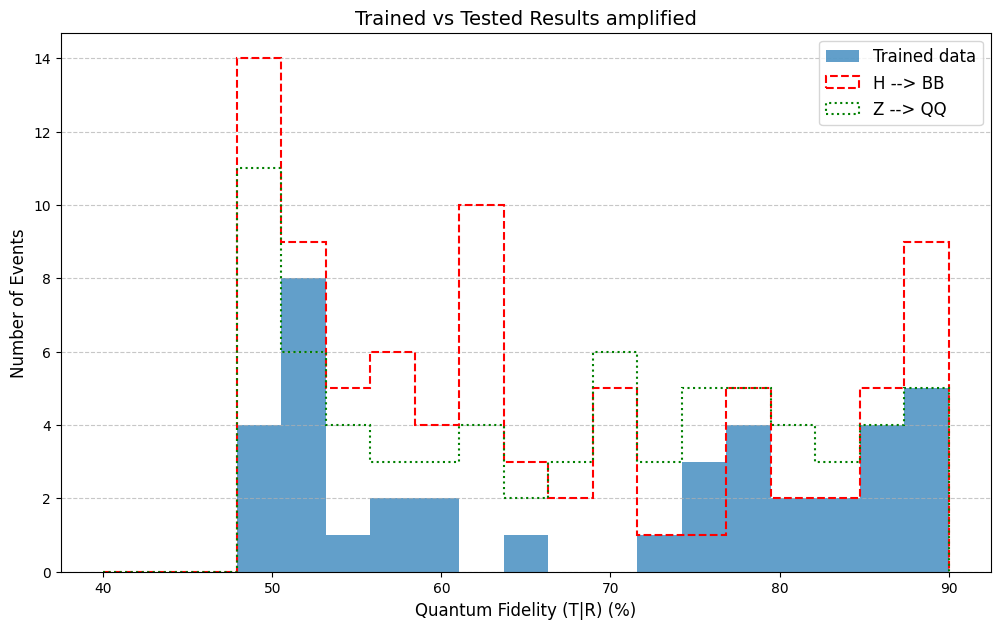

In [51]:
plt.figure(figsize=(12, 7))

# Definir bins
bins = np.linspace(40, 90, 20)

plt.hist(event_fidelities_back, bins=np.linspace(40, 90, 20), alpha=0.7, label='Trained data',)

# 2. Exotic (solo bordes, sin relleno)
plt.hist(event_fidelities_HToBB, 
         bins=bins, 
         edgecolor='red', 
         facecolor='none',  # Relleno transparente
         linewidth=1.5,     # Grosor del borde
         linestyle='--',    # Estilo de línea (opcional)
         label='H --> BB',
         histtype='step',  # Solo bordes
         stacked=True)

plt.hist(event_fidelities_ZToQQ, 
         bins=bins, 
         edgecolor='green', 
         facecolor='none',  # Relleno transparente
         linewidth=1.5,     # Grosor del borde
         linestyle=':',    # Estilo de línea (opcional)
         label='Z --> QQ',
         histtype='step',  # Solo bordes
         stacked=True)

# Personalización
plt.xlabel("Quantum Fidelity (T|R) (%)", fontsize=12)
plt.ylabel("Number of Events", fontsize=12)
plt.title("Trained vs Tested Results amplified", fontsize=14)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.legend(fontsize=12)

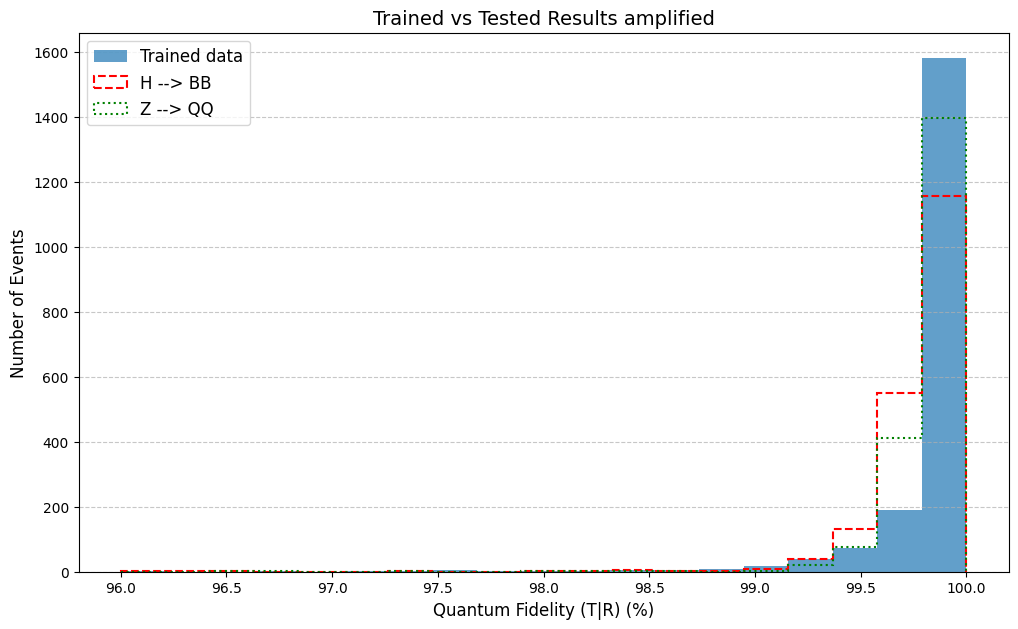

In [53]:
plt.figure(figsize=(12, 7))

# Definir bins
bins = np.linspace(96, 100, 20)

plt.hist(event_fidelities_back, bins=np.linspace(96, 100, 20), alpha=0.7, label='Trained data',)

# 2. Exotic (solo bordes, sin relleno)
plt.hist(event_fidelities_HToBB, 
         bins=bins, 
         edgecolor='red', 
         facecolor='none',  # Relleno transparente
         linewidth=1.5,     # Grosor del borde
         linestyle='--',    # Estilo de línea (opcional)
         label='H --> BB',
         histtype='step',  # Solo bordes
         stacked=True)

plt.hist(event_fidelities_ZToQQ, 
         bins=bins, 
         edgecolor='green', 
         facecolor='none',  # Relleno transparente
         linewidth=1.5,     # Grosor del borde
         linestyle=':',    # Estilo de línea (opcional)
         label='Z --> QQ',
         histtype='step',  # Solo bordes
         stacked=True)

# Personalización
plt.xlabel("Quantum Fidelity (T|R) (%)", fontsize=12)
plt.ylabel("Number of Events", fontsize=12)
plt.title("Trained vs Tested Results amplified", fontsize=14)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.legend(fontsize=12)

AUC (QCD vs HToBB): 0.7335
AUC (QCD vs ZToQQ): 0.6770


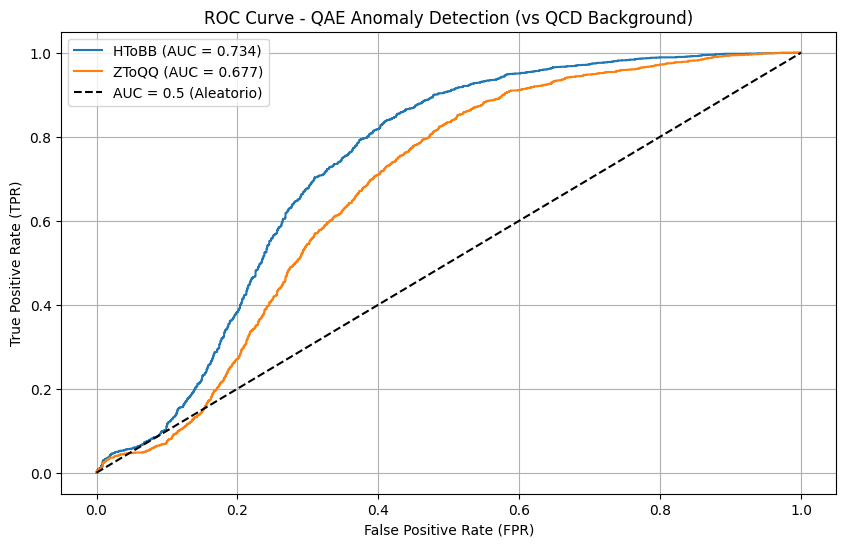

In [42]:
from sklearn.metrics import roc_auc_score, roc_curve
import matplotlib.pyplot as plt
import numpy as np

# 1. Calcular métricas de anomalía (1 - Fidelidad)
anomaly_scores_back = 1 - np.array(event_fidelities_back)
anomaly_scores_HToBB = 1 - np.array(event_fidelities_HToBB)
anomaly_scores_ZToQQ = 1 - np.array(event_fidelities_ZToQQ)

# 2. Calcular AUC para cada señal vs fondo
auc_HToBB = roc_auc_score(
    np.concatenate([np.zeros_like(anomaly_scores_back), np.ones_like(anomaly_scores_HToBB)]),
    np.concatenate([anomaly_scores_back, anomaly_scores_HToBB])
)

auc_ZToQQ = roc_auc_score(
    np.concatenate([np.zeros_like(anomaly_scores_back), np.ones_like(anomaly_scores_ZToQQ)]),
    np.concatenate([anomaly_scores_back, anomaly_scores_ZToQQ])
)

print(f"AUC (QCD vs HToBB): {auc_HToBB:.4f}")
print(f"AUC (QCD vs ZToQQ): {auc_ZToQQ:.4f}")

# 3. Graficar curvas ROC
plt.figure(figsize=(10, 6))

# Curva para HToBB
fpr_HToBB, tpr_HToBB, _ = roc_curve(
    np.concatenate([np.zeros_like(anomaly_scores_back), np.ones_like(anomaly_scores_HToBB)]),
    np.concatenate([anomaly_scores_back, anomaly_scores_HToBB])
)
plt.plot(fpr_HToBB, tpr_HToBB, label=f'HToBB (AUC = {auc_HToBB:.3f})')

# Curva para ZToQQ
fpr_ZToQQ, tpr_ZToQQ, _ = roc_curve(
    np.concatenate([np.zeros_like(anomaly_scores_back), np.ones_like(anomaly_scores_ZToQQ)]),
    np.concatenate([anomaly_scores_back, anomaly_scores_ZToQQ])
)
plt.plot(fpr_ZToQQ, tpr_ZToQQ, label=f'ZToQQ (AUC = {auc_ZToQQ:.3f})')

# Línea de referencia
plt.plot([0, 1], [0, 1], 'k--', label='AUC = 0.5 (Aleatorio)')
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('ROC Curve - QAE Anomaly Detection (vs QCD Background)')
plt.legend()
plt.grid(True)
plt.show()

## **Prueba con 4 qubits para comparar con el caso de 4 qutrits**

In [10]:
# --- Parámetros del circuito ---
num_particles = 4
num_latent = 1
num_ref = num_particles - num_latent
num_trash = num_ref
wires = list(range(num_particles + num_ref + 1))  # +1 ancilla
ancilla = wires[-1]
dev = qml.device("default.qubit", wires=wires)

latent_wire = 0
trash_wires = wires[1:num_particles]
ref_wires = wires[num_particles:-1]

import torch
import numpy as np

# --- Inicialización de parámetros ---
w = torch.tensor(1.0, requires_grad=True)
num_layers = 1
theta_i = (torch.rand(num_layers, num_particles) * 2 * torch.pi).requires_grad_(True)
phi_i   = (torch.rand(num_layers, num_particles) * 2 * torch.pi).requires_grad_(True)
w_i     = (torch.rand(num_layers, num_particles) * 2 * torch.pi).requires_grad_(True)

optimizer = torch.optim.Adam(
    [w, theta_i, phi_i, w_i],
    lr=0.01,
    betas=(0.9, 0.999),
    eps=1e-08,
    weight_decay=0.01,
    amsgrad=True
)

num_epochs = 1
all_fidelities = []
event_fidelities = []

# Asegúrate de tener tus datos cargados como:
# X_train = cargar_datos_json("runG_batch0_reducido.json")

# --- Entrenamiento ---
for epoch in range(num_epochs):
    total_loss = 0.0
    epoch_fidelities = []

    for jet in X_train:
        # Verificar que haya suficientes constituyentes
        if len(jet['constituents']) < num_particles:
            continue

        loss, fidelity = cost_function_with_fidelity(jet, w, theta_i, phi_i, w_i, num_layers)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        epoch_fidelities.append(fidelity)
        event_fidelities.append(fidelity * 100)  # en %

    avg_loss = total_loss / len(epoch_fidelities)
    avg_fidelity = np.mean(epoch_fidelities) * 100
    all_fidelities.append(avg_fidelity)

    print(f"Epoch {epoch+1}, Loss: {avg_loss:.4f}, Avg Fidelity: {avg_fidelity:.2f}%")


Epoch 1, Loss: -0.9863, Avg Fidelity: 98.63%


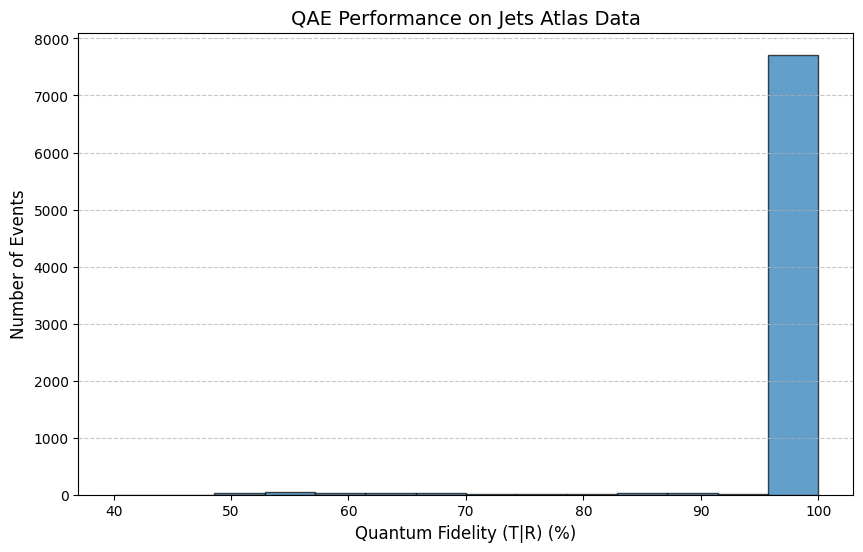

In [11]:
# --- Generación del Diagrama ---
plt.figure(figsize=(10, 6))
plt.hist(event_fidelities, bins=np.linspace(40, 100, 15), edgecolor='black', alpha=0.7)
plt.xlabel("Quantum Fidelity (T|R) (%)", fontsize=12)
plt.ylabel("Number of Events", fontsize=12)
plt.title("QAE Performance on Jets Atlas Data", fontsize=14)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.savefig("qae_fidelity_distribution.png", dpi=300, bbox_inches='tight')
plt.show()

In [14]:
from sklearn.metrics import roc_auc_score

event_fidelities_back = []
event_fidelities_HToBB = []
event_fidelities_ZToQQ = []
fidelidades = []
etiquetas = []

X_test_2 = X_test
for jet in X_test_2:
    # Verificar que haya suficientes constituyentes
    if len(jet['constituents']) < num_particles:
        continue
    _, fidelity = cost_function_with_fidelity(jet, w, theta_i, phi_i, w_i, num_layers)
    event_fidelities_back.append(fidelity * 100) 
    fidelidades.append(fidelity)
    etiquetas.append(0)

print("Terminada prueba de validación")

for jet in datos_HToBB:
    # Verificar que haya suficientes constituyentes
    if len(jet['constituents']) < num_particles:
        continue
    _, fidelity = cost_function_with_fidelity(jet, w, theta_i, phi_i, w_i, num_layers)
    event_fidelities_HToBB.append(fidelity * 100) 
    fidelidades.append(fidelity)
    etiquetas.append(1)

print("Terminada prueba con HToBB")

for jet in datos_ZToQQ:
    # Verificar que haya suficientes constituyentes
    if len(jet['constituents']) < num_particles:
        continue
    _, fidelity = cost_function_with_fidelity(jet, w, theta_i, phi_i, w_i, num_layers)
    event_fidelities_ZToQQ.append(fidelity * 100) 
    fidelidades.append(fidelity)
    etiquetas.append(1)

print("Terminada prueba con ZToQQ")

Terminada prueba de validación
Terminada prueba con HToBB
Terminada prueba con ZToQQ


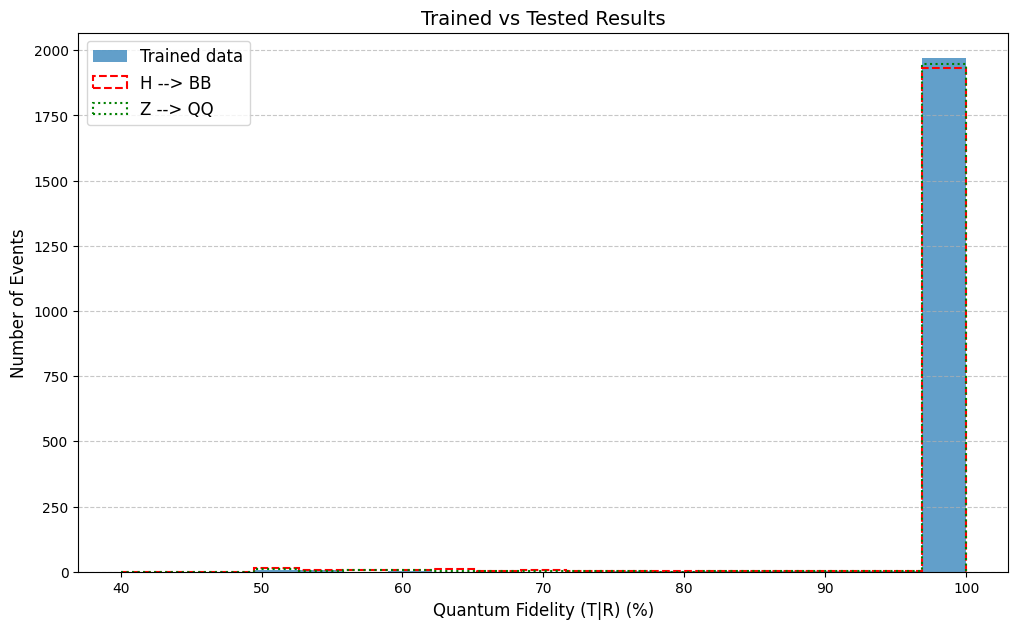

In [15]:
plt.figure(figsize=(12, 7))

# Definir bins
bins = np.linspace(40, 100, 20)

plt.hist(event_fidelities_back, bins=np.linspace(40, 100, 20), alpha=0.7, label='Trained data',)

# 2. Exotic (solo bordes, sin relleno)
plt.hist(event_fidelities_HToBB, 
         bins=bins, 
         edgecolor='red', 
         facecolor='none',  # Relleno transparente
         linewidth=1.5,     # Grosor del borde
         linestyle='--',    # Estilo de línea (opcional)
         label='H --> BB',
         histtype='step',  # Solo bordes
         stacked=True)

plt.hist(event_fidelities_ZToQQ, 
         bins=bins, 
         edgecolor='green', 
         facecolor='none',  # Relleno transparente
         linewidth=1.5,     # Grosor del borde
         linestyle=':',    # Estilo de línea (opcional)
         label='Z --> QQ',
         histtype='step',  # Solo bordes
         stacked=True)

# Personalización
plt.xlabel("Quantum Fidelity (T|R) (%)", fontsize=12)
plt.ylabel("Number of Events", fontsize=12)
plt.title("Trained vs Tested Results", fontsize=14)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.legend(fontsize=12)
plt.show() 

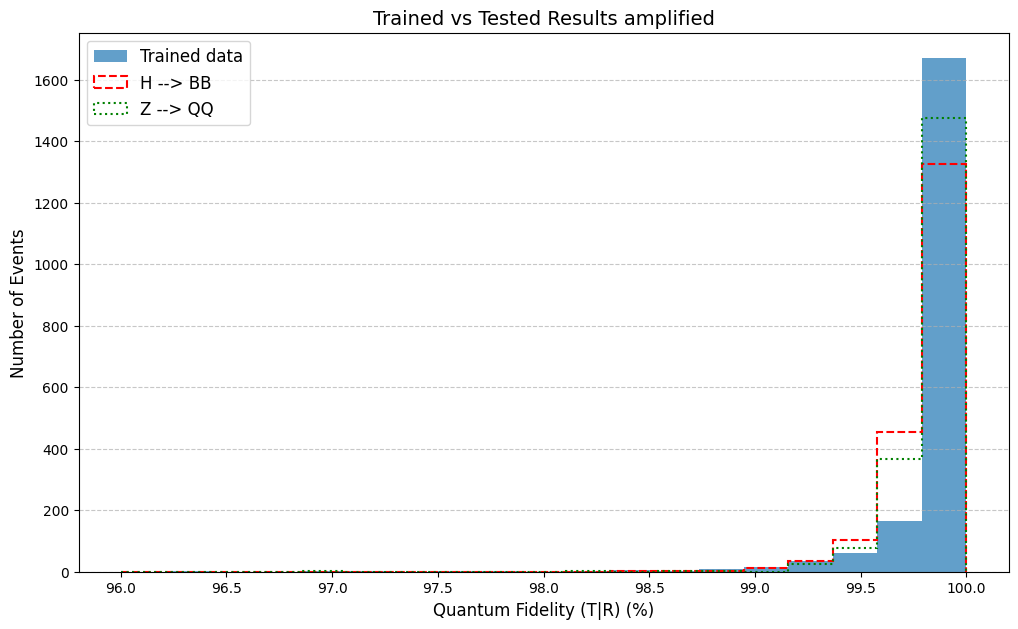

In [16]:
plt.figure(figsize=(12, 7))

# Definir bins
bins = np.linspace(96, 100, 20)

plt.hist(event_fidelities_back, bins=np.linspace(96, 100, 20), alpha=0.7, label='Trained data',)

# 2. Exotic (solo bordes, sin relleno)
plt.hist(event_fidelities_HToBB, 
         bins=bins, 
         edgecolor='red', 
         facecolor='none',  # Relleno transparente
         linewidth=1.5,     # Grosor del borde
         linestyle='--',    # Estilo de línea (opcional)
         label='H --> BB',
         histtype='step',  # Solo bordes
         stacked=True)

plt.hist(event_fidelities_ZToQQ, 
         bins=bins, 
         edgecolor='green', 
         facecolor='none',  # Relleno transparente
         linewidth=1.5,     # Grosor del borde
         linestyle=':',    # Estilo de línea (opcional)
         label='Z --> QQ',
         histtype='step',  # Solo bordes
         stacked=True)

# Personalización
plt.xlabel("Quantum Fidelity (T|R) (%)", fontsize=12)
plt.ylabel("Number of Events", fontsize=12)
plt.title("Trained vs Tested Results amplified", fontsize=14)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.legend(fontsize=12)

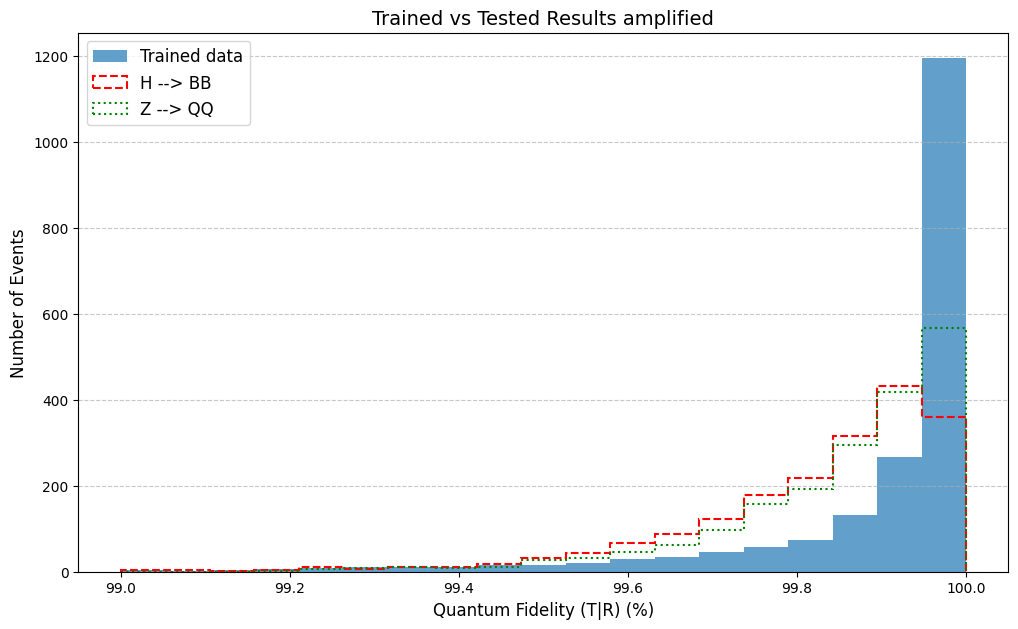

In [17]:
plt.figure(figsize=(12, 7))

# Definir bins
bins = np.linspace(99, 100, 20)

plt.hist(event_fidelities_back, bins=np.linspace(99, 100, 20), alpha=0.7, label='Trained data',)

# 2. Exotic (solo bordes, sin relleno)
plt.hist(event_fidelities_HToBB, 
         bins=bins, 
         edgecolor='red', 
         facecolor='none',  # Relleno transparente
         linewidth=1.5,     # Grosor del borde
         linestyle='--',    # Estilo de línea (opcional)
         label='H --> BB',
         histtype='step',  # Solo bordes
         stacked=True)

plt.hist(event_fidelities_ZToQQ, 
         bins=bins, 
         edgecolor='green', 
         facecolor='none',  # Relleno transparente
         linewidth=1.5,     # Grosor del borde
         linestyle=':',    # Estilo de línea (opcional)
         label='Z --> QQ',
         histtype='step',  # Solo bordes
         stacked=True)

# Personalización
plt.xlabel("Quantum Fidelity (T|R) (%)", fontsize=12)
plt.ylabel("Number of Events", fontsize=12)
plt.title("Trained vs Tested Results amplified", fontsize=14)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.legend(fontsize=12)

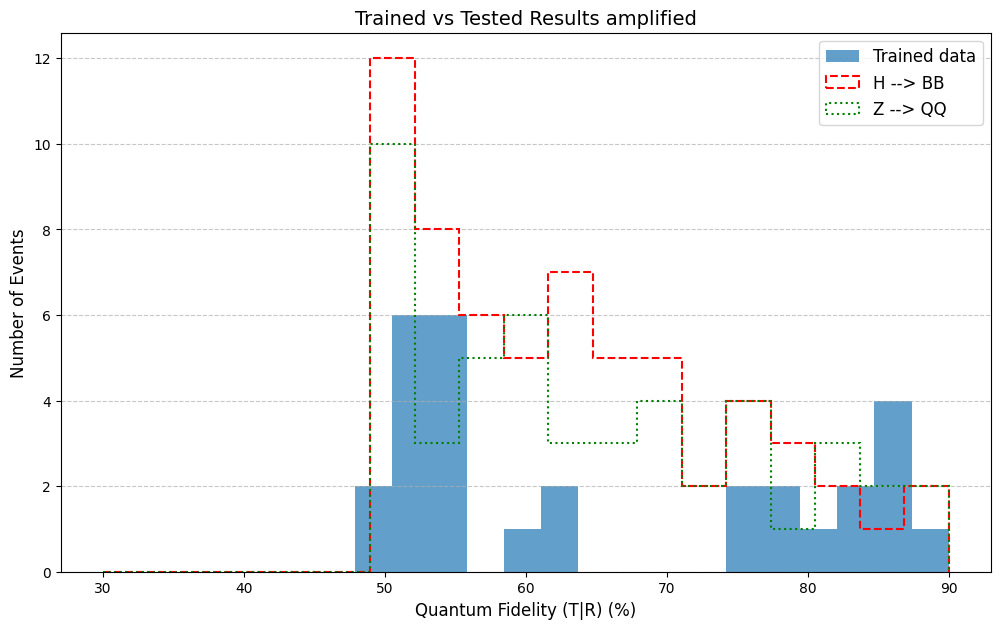

In [18]:
plt.figure(figsize=(12, 7))

# Definir bins
bins = np.linspace(30, 90, 20)

plt.hist(event_fidelities_back, bins=np.linspace(40, 90, 20), alpha=0.7, label='Trained data',)

# 2. Exotic (solo bordes, sin relleno)
plt.hist(event_fidelities_HToBB, 
         bins=bins, 
         edgecolor='red', 
         facecolor='none',  # Relleno transparente
         linewidth=1.5,     # Grosor del borde
         linestyle='--',    # Estilo de línea (opcional)
         label='H --> BB',
         histtype='step',  # Solo bordes
         stacked=True)

plt.hist(event_fidelities_ZToQQ, 
         bins=bins, 
         edgecolor='green', 
         facecolor='none',  # Relleno transparente
         linewidth=1.5,     # Grosor del borde
         linestyle=':',    # Estilo de línea (opcional)
         label='Z --> QQ',
         histtype='step',  # Solo bordes
         stacked=True)

# Personalización
plt.xlabel("Quantum Fidelity (T|R) (%)", fontsize=12)
plt.ylabel("Number of Events", fontsize=12)
plt.title("Trained vs Tested Results amplified", fontsize=14)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.legend(fontsize=12)

AUC (QCD vs HToBB): 0.7391
AUC (QCD vs ZToQQ): 0.6894


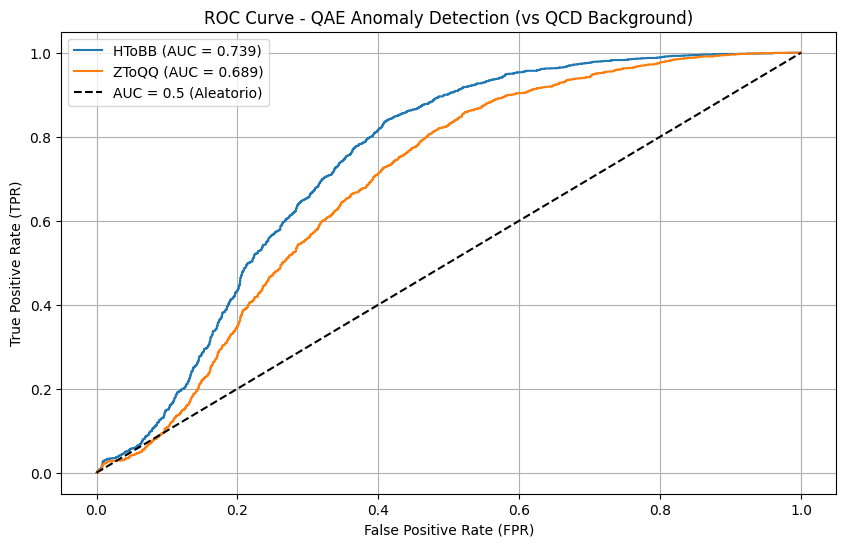

In [19]:
from sklearn.metrics import roc_auc_score, roc_curve
import matplotlib.pyplot as plt
import numpy as np

# 1. Calcular métricas de anomalía (1 - Fidelidad)
anomaly_scores_back = 1 - np.array(event_fidelities_back)
anomaly_scores_HToBB = 1 - np.array(event_fidelities_HToBB)
anomaly_scores_ZToQQ = 1 - np.array(event_fidelities_ZToQQ)

# 2. Calcular AUC para cada señal vs fondo
auc_HToBB = roc_auc_score(
    np.concatenate([np.zeros_like(anomaly_scores_back), np.ones_like(anomaly_scores_HToBB)]),
    np.concatenate([anomaly_scores_back, anomaly_scores_HToBB])
)

auc_ZToQQ = roc_auc_score(
    np.concatenate([np.zeros_like(anomaly_scores_back), np.ones_like(anomaly_scores_ZToQQ)]),
    np.concatenate([anomaly_scores_back, anomaly_scores_ZToQQ])
)

print(f"AUC (QCD vs HToBB): {auc_HToBB:.4f}")
print(f"AUC (QCD vs ZToQQ): {auc_ZToQQ:.4f}")

# 3. Graficar curvas ROC
plt.figure(figsize=(10, 6))

# Curva para HToBB
fpr_HToBB, tpr_HToBB, _ = roc_curve(
    np.concatenate([np.zeros_like(anomaly_scores_back), np.ones_like(anomaly_scores_HToBB)]),
    np.concatenate([anomaly_scores_back, anomaly_scores_HToBB])
)
plt.plot(fpr_HToBB, tpr_HToBB, label=f'HToBB (AUC = {auc_HToBB:.3f})')

# Curva para ZToQQ
fpr_ZToQQ, tpr_ZToQQ, _ = roc_curve(
    np.concatenate([np.zeros_like(anomaly_scores_back), np.ones_like(anomaly_scores_ZToQQ)]),
    np.concatenate([anomaly_scores_back, anomaly_scores_ZToQQ])
)
plt.plot(fpr_ZToQQ, tpr_ZToQQ, label=f'ZToQQ (AUC = {auc_ZToQQ:.3f})')

# Línea de referencia
plt.plot([0, 1], [0, 1], 'k--', label='AUC = 0.5 (Aleatorio)')
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('ROC Curve - QAE Anomaly Detection (vs QCD Background)')
plt.legend()
plt.grid(True)
plt.show()